In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyaldata
import h5py

from numpy.fft import fft, fftfreq

# %load_ext lab_black

Matplotlib created a temporary cache directory at /tmp/matplotlib-1qyoydch because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Plot behavior trajectories

In [2]:
from plot_helpers import plot_directions_per_epoch, plot_beh_pred_per_epoch, get_trials2plot, \
                        plot_fourier_AD, plot_fourier_last_sessions

In [3]:
area = 'M1'
path = f'../../datasets/Chewie_CO_FF_2016-10-07_session_vel_{area}_spikes_go.h5'
data = h5py.File(path, 'r')
data.keys()

<KeysViewHDF5 ['train_behavior', 'train_encod_data', 'train_epoch', 'train_inds', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_encod_data', 'valid_epoch', 'valid_inds', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>

In [4]:
dset='train'
vel = data[f'{dset}_behavior'][:]
target_direction = data[f'{dset}_target_direction'][:]
epoch = data[f'{dset}_epoch'][:]
spike_data = data[f'{dset}_recon_data'][:]

dset='valid'
vel = np.concatenate([vel,data[f'{dset}_behavior'][:]])
target_direction = np.concatenate([target_direction,data[f'{dset}_target_direction'][:]])
epoch = np.concatenate([epoch,data[f'{dset}_epoch'][:]])
spike_data = np.concatenate([spike_data,data[f'{dset}_recon_data'][:]])

pos = np.cumsum(vel*0.01,1)

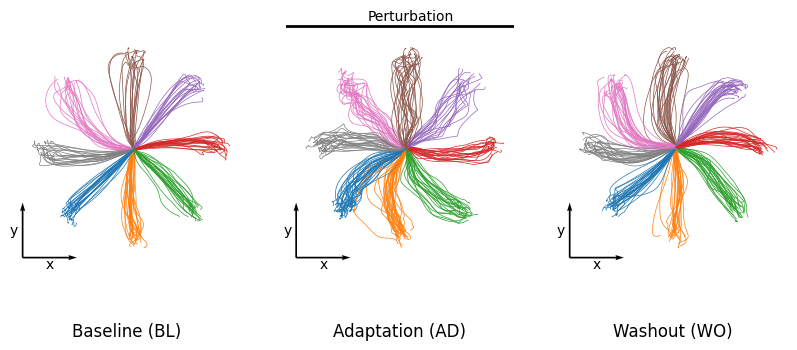

In [5]:
plot_directions_per_epoch(pos,target_direction,epoch)

## Calculate averages

In [6]:
dir_index = np.array([
        sorted(set(target_direction)).index(i) for i in target_direction
    ])
avg_pos = np.empty_like(pos)
avg_vel = np.empty_like(vel)

avg_pos_per_epoch = np.empty_like(pos)
avg_vel_per_epoch = np.empty_like(vel)

for d in range(8):
    mask = d==dir_index
    avg_pos[mask] = pos[mask].mean(0)
    avg_vel[mask] = vel[mask].mean(0)
    for e in [0,1,2]:
        mask = (d==dir_index) & (e==epoch)
        avg_pos_per_epoch[mask] = pos[mask].mean(0)
        avg_vel_per_epoch[mask] = vel[mask].mean(0)


In [7]:
trials2plot = np.array([get_trials2plot(vel, avg_vel, dir_index, epoch, i) for i in range(3)]).sum(0)
trials2plot.sum()

24

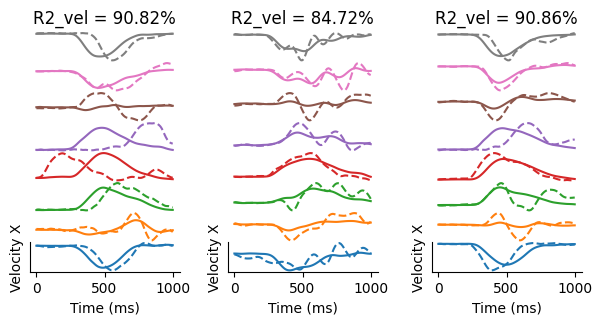

In [8]:
plot_beh_pred_per_epoch(vel, avg_vel_per_epoch, dir_index, trials2plot, epoch,component=0)

# Plot spectral analysis

## Set paths

In [9]:
raw_data_dir = (
    "/disk/scratch2/nkudryas/motor_cortex/perich_2018_binned/"
)
data_save_dir = "../../datasets/"

In [10]:
# just going to hard code this obviously change this if the data changes
experiments = [
    "Chewie_CO_FF_2016-09-15.mat",
    "Chewie_CO_FF_2016-09-21.mat",
    "Chewie_CO_FF_2016-10-05.mat",
    "Chewie_CO_FF_2016-10-07.mat", 
    "Mihili_CO_FF_2014-02-03.mat",  # *
    "Mihili_CO_FF_2014-02-17.mat",  # + (only BL)
    "Mihili_CO_FF_2014-02-18.mat",
    "Mihili_CO_FF_2014-03-07.mat",
]

# experiments = [
#     "Chewie_CO_VR_2016-09-09.mat",
#     "Chewie_CO_VR_2016-09-12.mat",
#     "Chewie_CO_VR_2016-09-14.mat",
#     "Chewie_CO_VR_2016-10-06.mat",
#     "Mihili_CO_VR_2014-03-03.mat",
#     "Mihili_CO_VR_2014-03-04.mat",
#     "Mihili_CO_VR_2014-03-06.mat",
# ]

## Set parameters

In [11]:
"""
activity_key : which neurons to load {"PMd_spikes", "M1_spikes", "all_spikes"}
behaviour_key : behaviour to train to (sometimes assumed to be velocity)
full_behaviour_key : the other behaviour (vel or pos). Here often assumed to be position
alignment : align trials to this point in the experinment. {"go"}
"""
activity_key = "all_spikes" #"PMd_spikes" # "all_spikes" #"M1_spikes"
behaviour_key = "vel"  # the main behavior used in training & validation

trial_len = 100

"""
dt : time step size - this actually depends on the bin window but I cant find where this is set - it is 10ms rn
"""
dt = 0.01


## Summarize velocity oscillations

In [12]:
# load all velocities for all sessions
Vel, Epoch = {}, {}
idx_go_cue, idx_movement_on, idx_peak_speed, idx_trial_end = {}, {}, {}, {}
for spike_data_dir in experiments:
    pd_data = pyaldata.io.mat2dataframe(
        path=raw_data_dir + spike_data_dir, shift_idx_fields=True
    )

    # trials must be successful to be included
    selected_trials = pd_data.loc[
            (pd_data.result == "R") & (pd_data['vel'].apply(lambda x: np.all(np.abs(x) < 100)))
        ]

    
    Vel[spike_data_dir] = np.asarray(
            [
                d[f'vel'][d.idx_trial_end - trial_len : d.idx_trial_end, :]
                for _, d in selected_trials.iterrows()
            ]
        )
    
    # epoch (BL/AD/WO) for each trial
    Epoch[spike_data_dir] = np.asarray(
            [
                d['epoch']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    idx_go_cue[spike_data_dir] = np.asarray(
            [
                d['idx_go_cue']
                for _, d in selected_trials.iterrows()
            ]
    )   

    idx_movement_on[spike_data_dir] = np.asarray(
            [
                d['idx_movement_on']
                for _, d in selected_trials.iterrows()
            ]
    )

    idx_peak_speed[spike_data_dir] = np.asarray(
            [
                d['idx_peak_speed']
                for _, d in selected_trials.iterrows()
            ]
    )   

    idx_trial_end[spike_data_dir] = np.asarray(
            [
                d['idx_trial_end']
                for _, d in selected_trials.iterrows()
            ]
    )

/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


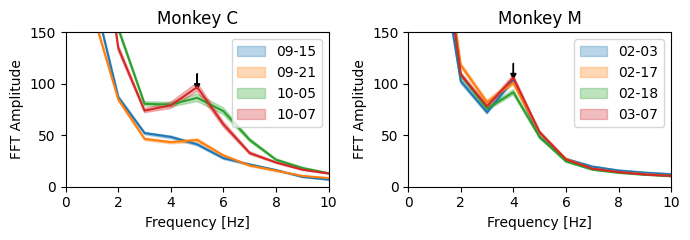

In [13]:
fig, axes = plt.subplots(1,2,figsize=(7,2.5))

plot_fourier_AD(axes, Vel, Epoch, experiments)
plt.tight_layout()

In [14]:
spike_data_dir = 'Chewie_CO_VR_2016-09-09.mat'

AD_start = np.where(Epoch[spike_data_dir]=='AD')[0][0]

V = Vel[spike_data_dir][AD_start+10:AD_start + 20, :] # get data for AD trials, time point 80 onwards

T = dt * V.shape[1]

for t in range(10):
    plt.plot(V[t,:,0])

KeyError: 'Chewie_CO_VR_2016-09-09.mat'

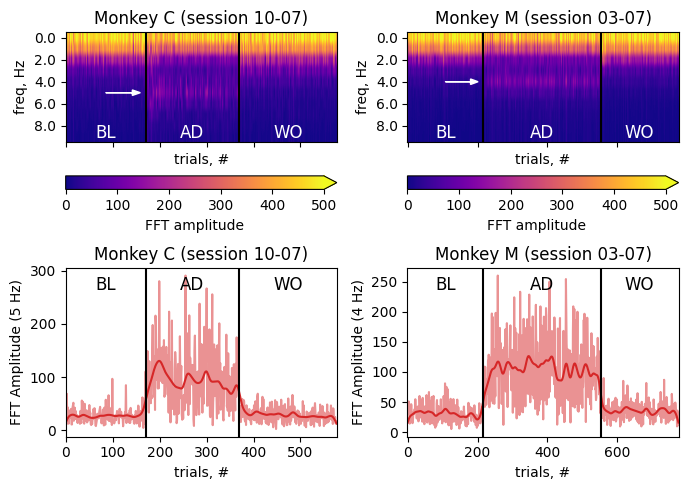

In [15]:
fig, axes = plt.subplots(2,2,figsize=(7,5),sharex='col')

for i, (m, spike_data_dir, peak_fr) in enumerate(zip(['C','M'],[experiments[3],experiments[-1]],[5,4])):
    plot_fourier_last_sessions(axes[0,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='spectrum', peak_freq = peak_fr)
    plot_fourier_last_sessions(axes[1,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='top_freq', peak_freq = peak_fr, color='C3')
plt.tight_layout()


## figs for supplementary

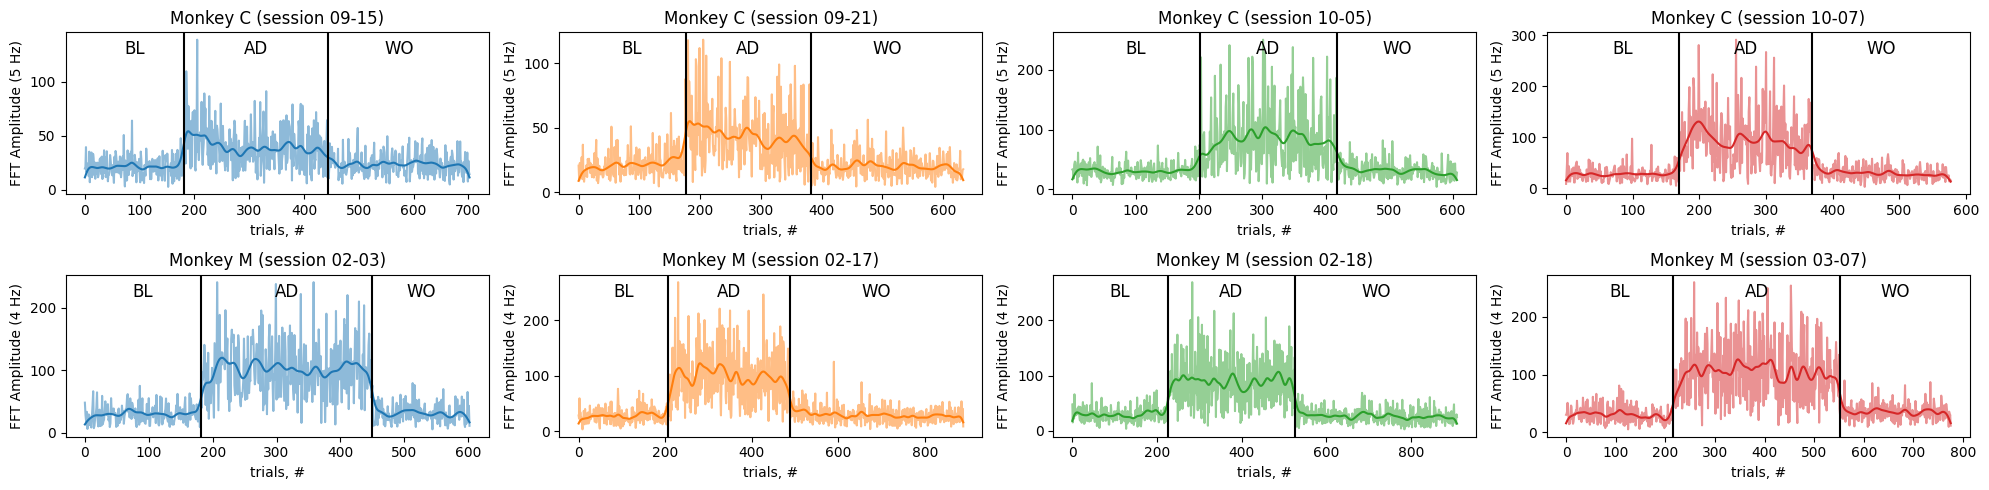

In [17]:

fig, axes = plt.subplots(2,4,figsize=(20,5))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    for i,spike_data_dir in enumerate(exps):
        plot_fourier_last_sessions(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='top_freq', peak_freq = peak_fr,color=f'C{i}')
        

plt.tight_layout()
fig.savefig('./figs/Figure3e_sup.pdf')

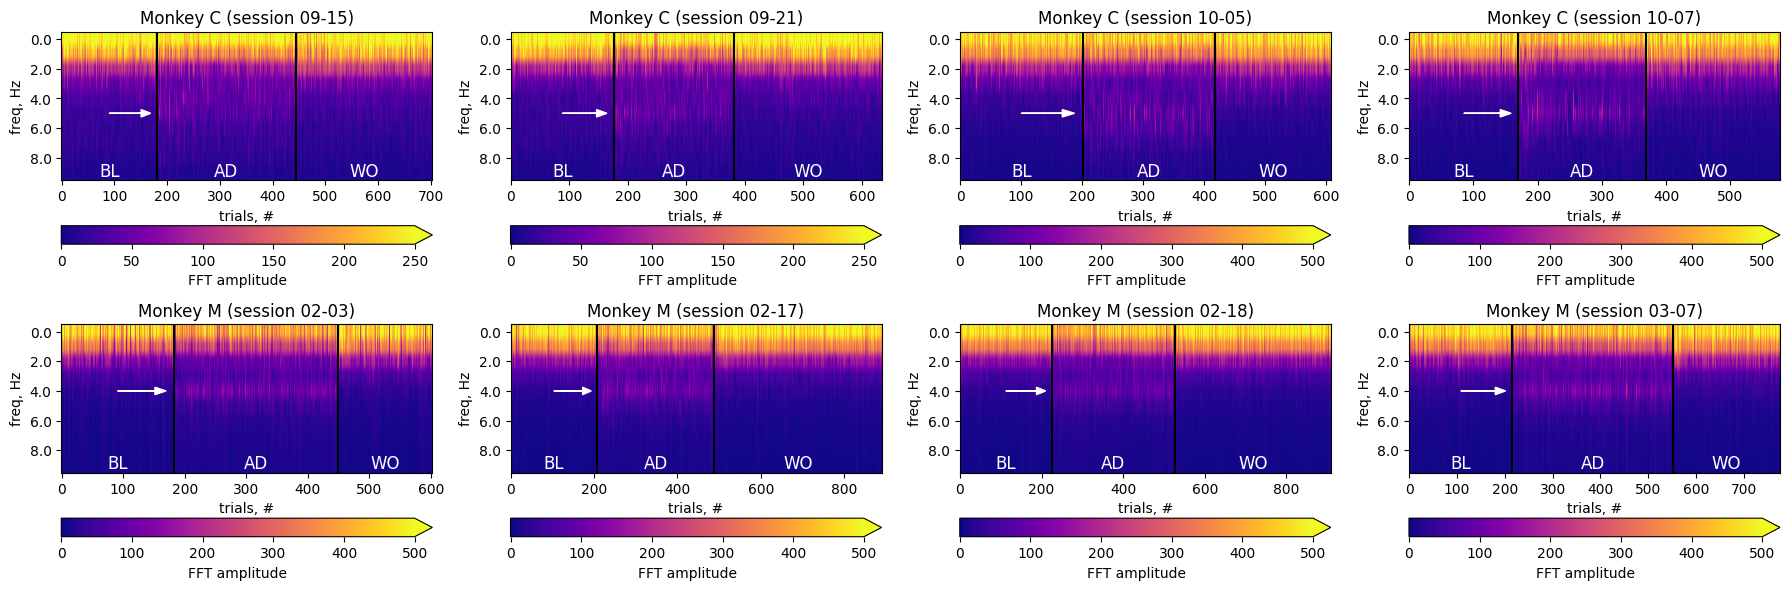

In [18]:

fig, axes = plt.subplots(2,4,figsize=(18,6))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    for i,spike_data_dir in enumerate(exps):
        vmax = 250 if (j==0) & (i<2) else 500
        plot_fourier_last_sessions(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='spectrum', peak_freq = peak_fr, vmax=vmax)
        
plt.tight_layout()
fig.savefig('./figs/Figure3d_sup.pdf')

## Check reaction time of Chewie vs Mihili (unused)

Chewie_CO_FF_2016-09-15.mat 231.74964438122333
Chewie_CO_FF_2016-09-21.mat 247.41324921135646
Chewie_CO_FF_2016-10-05.mat 241.26644736842107
Chewie_CO_FF_2016-10-07.mat 246.98961937716263
Mihili_CO_FF_2014-02-03.mat 283.167495854063
Mihili_CO_FF_2014-02-17.mat 253.4606741573034
Mihili_CO_FF_2014-02-18.mat 263.6303630363036
Mihili_CO_FF_2014-03-07.mat 241.72680412371133


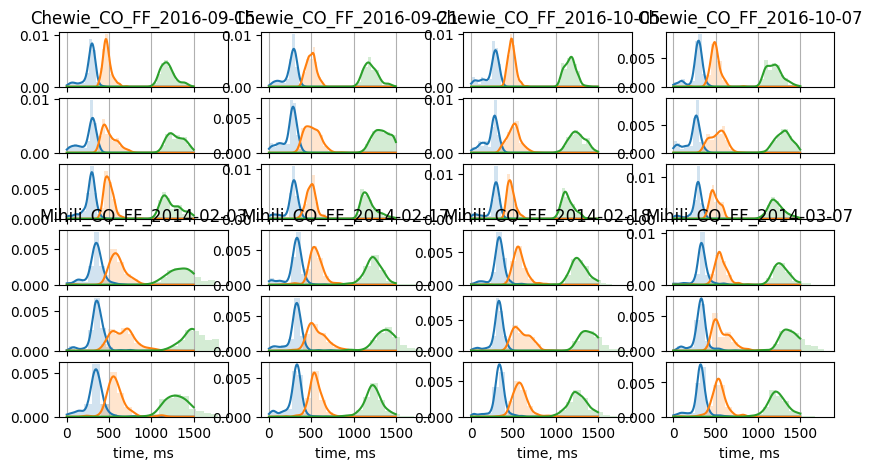

In [163]:
from scipy import stats

fig, axes = plt.subplots(2*3,4,figsize=(10,5),sharex=True)
for i, (m, exps) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]])):

    for j, exp in enumerate(exps):
        for k, e in enumerate(['BL','AD','WO']):

            ax = axes[i*3 + k,j]
            dels = 10*(idx_movement_on[exp]-idx_go_cue[exp])[epoch[exp]==e]
            ax.hist(dels, density=True, color='C0',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C0')

            dels = 10*(idx_peak_speed[exp]-idx_go_cue[exp])[epoch[exp]==e]
            ax.hist(dels, density=True, color='C1',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C1')

            dels = 10*(idx_trial_end[exp]-idx_go_cue[exp])[epoch[exp]==e]
            ax.hist(dels, density=True, color='C2',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C2')

            if k == 0:
                ax.set_title(exp.split('.mat')[0])
            if k == 2:
                ax.set_xlabel('time, ms')
            ax.grid(which='major', axis='x', zorder=-1.0)

        print(exp,np.mean(idx_peak_speed[exp]-idx_movement_on[exp])*10)
plt.savefig('time_progress.svg')

# Make figure layout

In [39]:
from goodman_panels import panels, panel_specs, label_panel, label_panels

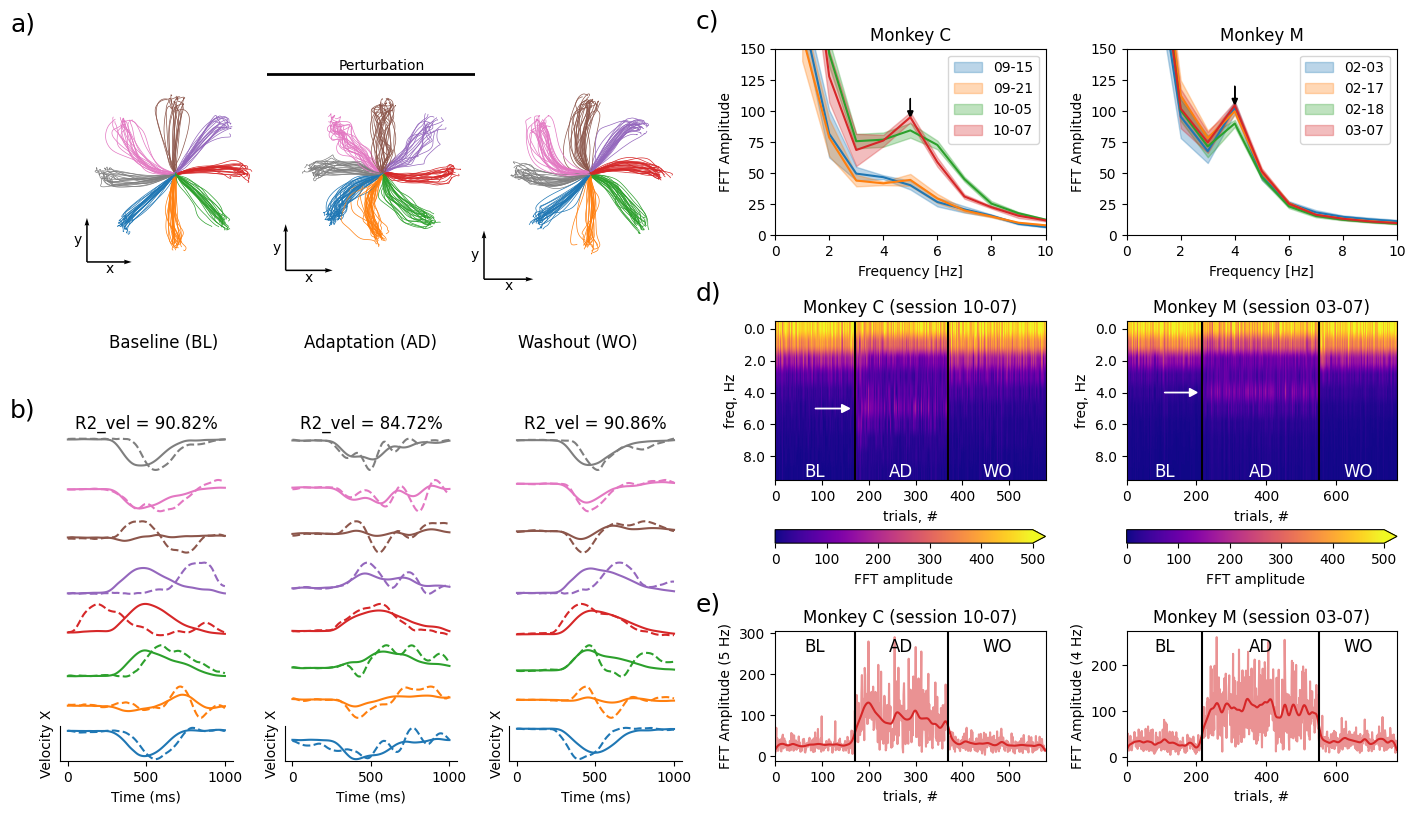

In [221]:
layout = '''
AC
AD
BD
BE
'''
fig = plt.figure(figsize=(14, 8))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.035, 'right': .99, 'bottom': 0.06, 'top': 0.95, 'hspace': .5, 'wspace': .15})
axes = {}
gs.set_width_ratios([1,1])
gs.set_height_ratios([1.6,.4,1,1])

###############################################################

subgs = specs['A'].subgridspec(1, 3, wspace=0.0)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    if i ==0:
        axes[f"A{i}"] = ax = fig.add_subplot(subgs[i],aspect=1.)
    else:
        axes[f"A{i}"] = ax = fig.add_subplot(subgs[i],aspect=1.,sharex=axes['A0'],sharey=axes['A0'])
    # manually move up
    p = ax.get_position()
    ax.set_position([p.x0, p.y0+.03, p.width, p.height])
label_panel(axes['A0'], 'a', postfix=')',offset_left=0.5,offset_up=0.53)

subgs = specs['B'].subgridspec(8, 3, wspace=0.3)
for j in range(8):
    for i in range(3):
        axes[f"B{j}{i}"] = ax = fig.add_subplot(subgs[j,i])
label_panel(axes['B00'], 'b', postfix=')',offset_left=0.5)

ws = .3

subgs = specs['C'].subgridspec(1, 2, wspace=ws)
for j in range(2):
    axes[f"C{j}"] = ax = fig.add_subplot(subgs[j])
    # manually shrink
    p = ax.get_position()
    ax.set_position([p.x0, p.y0+0.1*p.height, p.width, 0.9*p.height])
label_panel(axes['C0'], 'c', postfix=')')

subgs = specs['D'].subgridspec(1, 2, wspace=ws)
for j in range(2):
    axes[f"D{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['D0'], 'd', postfix=')')

subgs = specs['E'].subgridspec(1, 2, wspace=ws)
for j in range(2):
    axes[f"E{j}"] = ax = fig.add_subplot(subgs[j],sharex=axes[f'D{j}'])
label_panel(axes['E0'], 'e', postfix=')')

#################################################################

plot_directions_per_epoch(pos,target_direction,epoch,axes = [axes[f'A{i}'] for i in range(3)])

plot_beh_pred_per_epoch(vel, avg_vel_per_epoch, dir_index, trials2plot, epoch,component=0, ax_vel = [[axes[f'B{j}{i}'] for j in range(7,-1,-1)] for i in range(3)])

plot_fourier_AD([axes[f'C{j}'] for j in range(2)])

for i, (m, spike_data_dir, peak_fr) in enumerate(zip(['C','M'],[experiments[3],experiments[-1]],[5,4])):
    plot_fourier_last_sessions(axes[f'D{i}'], monkey=m, spike_data_dir=spike_data_dir, plot='spectrum', peak_freq = peak_fr)
    plot_fourier_last_sessions(axes[f'E{i}'], monkey=m, spike_data_dir=spike_data_dir, plot='top_freq', peak_freq = peak_fr, color='C3')

fig.savefig('./figs/Figure3.pdf')

---

# Create two sets - subsampling neurons according to oscillating/non-oscillating.

In [ ]:
# identify neurons which are oscillating based on the power5 array

print(oscillation_threshold)
# n_m1 = 70 # number of m1 neurons in the set we are only going to care about m1 neurons oscillating
# n_total = 207

total_neurons = len(power5)
oscillating_criteria = np.where(np.array(power5)>oscillation_threshold)[0]
oscillating_neurons = [x for x in oscillating_criteria if x<=num_m1_units] # idx for oscillating neurons
# non_oscillating_neurons = np.where(np.array(power5)<=oscillation_threshold)[0] # since there are nans caused by the fourier transform, just take anything not flagged as oscillating
non_oscillating_neurons = [x for x in np.arange(0,207) if (x not in oscillating_neurons)]
if ablation_study:


    # calculate number of train and test neurons
    # neurons_per_set = total_neurons - len(oscillating_neurons) # subsample neurons based on number of oscillating neurons


    # oscillation_control set contains neurons which oscillate
    # randomly subset neurons_per_set
    # np.random.seed(38) # dont change this
    # poss_array = sorted(np.random.choice(np.arange(0,70), neurons_per_set, replace=False))
    # # sneaky check that we kept all the oscillating neurons
    # len([x for x in poss_array if x in oscillating_neurons])==10

    # oscillation_ablation set contain neurons which do not oscillate

    neurons_to_keep = non_oscillating_neurons # dont ablate these
    print(oscillating_neurons)
    print(len(oscillating_neurons))
    # len(neurons_to_keep)
else:
    neurons_to_keep = np.arange(0, len(power5))


0.6
[]
0


# check tuning of oscillating neurons

In [ ]:

# aligned spike data - excludes neurons if ablation_study=True
all_spike_data = np.asarray(
        [
            d[activity_key][d[start_key] : d[start_key] + shortest_trial, neurons_to_keep]
            for i, d in successful_trials.iterrows()
        ]
    )
print(all_spike_data.shape)

# target directions for each trial
target_directions = np.asarray([d["target_direction"] for i, d in successful_trials.iterrows()])
print(target_directions.shape)
# as above but index
set_directions = sorted(set(target_directions))
dir_index = np.array([set_directions.index(i) for i in target_directions])
print(len(dir_index))


NameError: name 'successful_trials' is not defined

In [ ]:
shortest_trial
# all_spike_data.shape[1]

47

In [ ]:


trials_by_direction_dict = {i:all_spike_data[list(np.where(dir_index==i)[0]),:,:] for i in np.unique(dir_index)}
trial_inds_by_direction_dict = {i: np.where(dir_index==i)[0] for i in np.unique(dir_index)}


NameError: name 'dir_index' is not defined

In [ ]:
# fr = spike_data[:AD_start, 100:]

def get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, neuron, AD_start, WO_start):

    pow5_dict = {}
    for dir_ind, trial_inds in trial_inds_by_direction_dict.items():
        trial_inds_AD = [tr for tr in trial_inds if tr>=AD_start and tr<WO_start] # get adaptation trials for condition
        fr = spike_data[trial_inds_AD, 80:, neuron] # get data for AD trials, time point 80 onwards
        # print(fr.shape)

        T = dt * fr.shape[1]

        # power5 = []
        # for i in range(fr.shape[-1]): # for each neuron
        # if i==0:
        x = fr # get the AD spike data for neuron i

        # x = (x - x.mean(0)) / x.std(0) # z score by mean over trials for each timepoint

        xf = fft(x)  # Compute Fourier transform of x
        Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum
        Sxx = np.nanmean(Sxx, axis=0)  # trial average per epoch

        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

        j = 4 # timepoint of interest...?
        # print(faxis[j],Sxx.real[j])
        # print(Sxx.real[j-1], Sxx.real[j], Sxx.real[j+1])
        pow_entry = (Sxx.real[j]/(Sxx.real[j-1]+Sxx.real[j+1]))
        if np.isnan(pow_entry):
            pow_entry = 0
        pow5_dict[dir_ind] = pow_entry # power at 5Hz

        # SR = Sxx.real
        # SR[SR>0.05] = 0.05
    return pow5_dict

In [ ]:
get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, 1, AD_start, WO_start)

NameError: name 'trial_inds_by_direction_dict' is not defined

In [ ]:
# this_trial_type = trials_by_direction_dict[0]
# neuron = 0

def plot_tuning_for_neuron(neuron, pow5_dict, trials_by_direction_dict, set_directions):
    # dict of {cond_index : power} pairs

    avg_activity_by_cond = []
    max_activity_by_cond = []

    for i, trials_for_dir in trials_by_direction_dict.items():
        trials_for_neuron = trials_for_dir[:,:before_align_point,neuron]
        avg_across_trials = np.nanmean(trials_for_neuron, axis=0) ##

        # average and max avg activity across trials of this type
        avg_across_time = avg_across_trials.mean()
        # print(avg_across_time)
        avg_activity_by_cond.append(avg_across_time)

        max_across_time = avg_across_trials.max()
        # print(max_across_time)
        max_activity_by_cond.append(max_across_time)

        # xax = np.arange(0, avg_across_trials.shape[0])
        # plt.plot(xax, avg_across_trials)

    pow5_by_cond = list(pow5_dict.values()) 

    # for i, dir in enumerate(set_directions):
    #     print(dir, avg_activity_by_cond[i], pow5_by_cond[i])

    fig, ax = plt.subplots(1,1, figsize=(5,5))

    ax.plot(set_directions, avg_activity_by_cond, label='avg activity')
    ax.plot(set_directions, pow5_by_cond, label='power at 5Hz')

    ax.set_xlabel('Condition direction')
    ax.set_xticks(set_directions)
    ax.set_ylabel('Power at 5Hz within condition')
    ax.set_title(f'by condition, neuron {neuron}')
    ax.legend(loc='upper left')
    # ax[0].set_ylim([0.0,0.05])

    


In [ ]:
# neuron = 0

for neuron in oscillating_neurons:
    pow5_dict = get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, neuron, AD_start, WO_start)
    plot_tuning_for_neuron(neuron, pow5_dict, trials_by_direction_dict, set_directions)